<!-- dom:TITLE: Machine Learning Methods for Events Classification in AT-TPC -->
<!-- dom:AUTHOR: Author: Ceulemans Andreas, Fracassetti Stefano, Morselli Luca, Haoran Sun, Youssef Ahmed  -->
<!-- Author: -->  

# <span style="color:darkred"> Machine Learning Methods for Events Classification in AT-TPC</span>    


**Authors:** Ceulemans Andreas<sup>1</sup>, Fracassetti Stefano<sup>1</sup>, Morselli Luca<sup>2</sup>, Sun Haoran<sup>3</sup>, Youssef Ahmed<sup>1</sup>.  


**<sup>1</sup>** KU Leuven University - Leuven, Belgium    
**<sup>2</sup>** University of Ferrara - Ferrara, Italy, and INFN LNL - Legnaro, Italy   
**<sup>3</sup>** Kent State University - Kent, (Ohio)US  


**Date:** August 31, 2020  


**Acknowledgements:**  
We would like to give special thanks to the <a href="https://www.ectstar.eu/talents/talent-school-special-edition-2020/">Talent School 2020</a> professors for the course offered on Machine Learning.    
The course was given by the <a href="http://fribtheoryalliance.org/TALENT/">TALENT Initiative</a>, at <a href="https://www.ectstar.eu/">ECT* in Trento</a>.  


   
**Credits:**  

*Ceulemans Andreas:* (to be completed)  
- He helped in the organization of the project, and the working plan.  

- He wrote the first version of the project: Data Import, and Data Visualization. As well as most of the helper_functions concerning this sections.  

- His contributions to the ML Algorithms:
    - LR (Logistic Regression),
    - RF (Random Forest) with Grid Search,
    - DNN (Dense Neural Network),
    - KM (K-Means),
    - SVM (Support Vector Machine),
    - Voting Classifier,
    - Revision of the DRA (Dimensionality Reduction Algorithm) (written by YA): PCA, and t-SNE, and adding 2D visualizations, through the function make_2d_vis.
    
- He wrote the first version of the Test Set Performances section.
    
***    
*Fracassetti Stefano:*
 
-  He organized the project work: setting regular meetings, managing the working plan, and keeping the folder/information up to date.

- Conversion of the first part of the report (already written by AC): Data Import and Data Exploration, in a format suited for the report i.e. adding a description/comment of each part, and improving visualization/plots. He moved most of the code in helper_functions (when possible) for better readibility of the report.

- His contributions to the ML Algorithms:
    - He wrote its own versions of LR, RF and DNN, and used the results to tune the parameters in the final versions.
    - KM (K-Means): he desinged the function best_cl_km(), extending the previous one (written by AC) to work an arbitrary number of clusters.
    - CNN (Convolution Neural Networks): he designed this section, and the relative functions.
    - DRA (Dimensionality Reduction Algorithms): contributions in the part relative to the Autoencoder (written by LM), moving part of the code in helper_functions, and improving the visualizaton.
 
- He marged the different parts in the final report, and checked its consistency. He helped with the final revision of the project.  

*This project was really helpful for me approaching Python, and as a first introduction to the ML world!* 


***
*Morselli Luca:*  

- His contributions to the ML Algorithms:
    - CNN (Convolution Neural Networks): minor contributions in setting model parameters and network structure (written by SF).
    - DRA (Dimensionality Reduction Algorithms): he designed the AutoEncoder section, and its functions.
    - KM (K-Means): he used the algorithm in order to cluster AutoEncoder latent space data. 
    - Revison of the Test Set Performances (written by AC), adding DNAs.
    
- He helped in the revision of the final report.  


***
*Sun Haoran:*  


- Contributions in the data visualization, and data demostration.  

- He helped in debugging, and contributed to the helper functions.  


***
*Youssef Ahmed:*  (to be completed)  

- His contributions to the ML Algorithms:
    - He wrote the DMA (Dimensionality Reduction Algorithms): PCA, and t-SNE.



# <span style="color:darkred">Description of the Project</span> 
(For better rendering, open the report locally with Jupyter Notebook, GitHub does not offer the best visualization).

## Task
The main objective of this project is to classify events (simulated data) acquired from the Active Target AT-TPC \[1\] as being "beam" or "reaction" events. The idea is to implement a "software trigger" which would be able to effectively select only relevant data to save disk space for future analysis. The project task is described in the <a href="https://github.com/fracassetti-stf/AT_Project/blob/master/AT_Project_Specifications.pdf">Project Specifications</a>.

We will apply the ML techniques learned during the <a href="https://www.ectstar.eu/talents/talent-school-special-edition-2020/">Talent School 2020</a>, in order to analyse the data and to reach the best performance.<br>  

\[1\]: <a href="https://www.sciencedirect.com/science/article/pii/S0168900218313342">Next-generation experiments with the Active Target Time Projection Chamber (AT-TPC)</a> for more information on AT-TPC.   

## Tabel of Content:

### Data Import
In this section we deal with the data import, and we perform the first basic operations on the data.
- Data Import: from HDF5 to Python
- Data Storage: Nested List
- Data Labeling (supervised learning): Beam or Reaction events?
- Data Cleaning: removing all empty events.
- Data Splitting: Train, Validation, and Test through Scikit-learn

### Data Exploration
In this section we visualize the data, to get a first insight on the events. We then extract features that we consider meaningful for the classification task, finally we visualize the features through histograms, and 2D plots.
 
- Data Visualization: 3D plot, and 2D Pad Plane projections.
- Feature Selection: Defining features for the classification task
- Features Visualization (and the otliers)
- Design Matrix
- Data Scaling

### Machine Learning
In this section we propose various approaches to perform the classification task, and we show the results obtained by each method. Evetually we evaluate the model performances on the test set, and write the conclusions.

- Logistic Regression
- Random Forest, with Grid Search    
- DNN - Dense Neural Networks
- K-Means, varying clusters number    
- Support Vector Machine


- CNN - Convolutional Neural Network
    - From events to images
    - CNN algorithm
    
    
- Dimensionality Reduction Algorithms
    - PCA
    - t-SNE
    - Autoencoder
    

## Common Import

In [1]:
import os
import sys
import math

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
    
import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

from helper_functions import *

# Aliases
layers = tf.keras.layers
# Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# <span style="color:darkred">Data Import</span> 

## Data Format
Data are saved in <a href="https://github.com/fracassetti-stf/AT_Project/blob/master/AT_Project_Specifications.pdf">DataFiles/Mg22_alphaalpha_digiSim.h5</a>, which contains 2000 simulated events: even numbers are "beam" events, while odd numbers are "reaction" event. Each event is constitued by a point cloud of the active pads for that events. The number of active pads may vary for each event, ranging from around 20, up to a few hundred.  

Each active pad is associated with a 5-tuple (x, y, z, t, A): 
- (x,y) are the positions of the active pad on the detector plane, 
- z is the coordinate associated with the beam axis,
- t is the time associated with the pad signal, and
- A is the charge deposited on the pad.<br> 

The time information is unnecessary since data already contains the z coordinate thanks to a preprocessing phase. There is also an extra column of zeros, which do not carry any meaningful information.<br>


## Let's have a look at the data file 

###  HDF5 file Format

First, we load the data, which are stored as a HDF5 file (Hierarchical Data File), which is designed to store and organize large amounts of data. The HDF5 file structure includes only two types of objects:

- Datasets: multidimensional arrays of a homogenous type
- Groups: container structures, that can hold Datasets or other groups

What's important to remember is that when opening an HDF5 in python through the command:
```
hf = f = h5py.File('./path/to/file', 'r')
```
we are creating a file object in which "Groups work like Dictionaries, and DataSets work like NumPy arrays": it is possible to check the datasets/groups contained in the file by typing:
``` 
list(hf.keys())
```

###  Mg22_alphaalpha_digiSim.h5

In this file, there were no groups, but 2000 datasets each one corresponding to an event.  
Each event/key is a 2D-array which contains 6 columns (x, y, z, t, A, 0), and multiple rows (corresponding to the number of active pads).

- We first want to give a table view of the data by printing the first event as an example:<br>
```
pd.DataFrame(hf.["Event_[i]"])
```

- We then want to visualise the length of the data. How many events are we dealing with?<br>
```
len(list(hf.keys()))
```
Here we can se that the there are 2000 events.
<br/><br/>
    
- It is interesting to print a few event types to see how many pads were written per event:<br>
```
list(hf.keys())
hf["Event_[i]"]
```   
The keys have the name *Event_\[ i \]* (where *i* is the event number), and it is possible to notice that reaction events have consistently more active pads in respect to beam events.
<br/><br/>

- Eventually we will plot the entire set of information for a specific event:<br>
```
hf["Event_[0]"].dtype
hf["Event_[0]"][:]    
```

## Loading the Data
We will first load the datafile, and visualize Event_\[ 0 \]:  


DataSet: Mg22_alphaalpha_digiSim.h5  
Event Number: 0  
Label: Beam  

In [2]:
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

#Table view of the event
Event_0=pd.DataFrame(hf["Event_[0]"][:])
display(Event_0)

,x,y,z,t,A,trackID
0,-2.454130,1.450752,834.0,417,6733.605773,0
1,-0.000013,2.799905,834.0,417,12585.463255,0
2,-2.454130,-1.450752,834.0,417,1705.208085,0
3,2.454133,-1.450752,900.0,450,3778.845219,0
4,-0.000013,-2.799905,900.0,450,11368.678344,0
5,2.454133,1.450752,962.0,481,3210.764796,0
6,4.908251,-5.701409,964.0,482,44.570651,0
7,2.454104,7.050561,966.0,483,21.112801,0
8,-2.454131,-7.050561,984.0,492,19.055387,0
9,-4.908247,5.701409,986.0,493,19.747327,0


## Data Types

###  Nested List
This seems to be the most suited structure to handle these data, where every element of the list is an event. Each dataset has a different length, and lists are able to effectively handle this.
In the next cell, we import the data in a list.
Each element of a list corresponds to a single event of the HDF5 file. We can easily verify that, e.g. checking that the two lines below have the same output:

```
    print(hf["Event_[0]"][:])
    print(DataList[0])
```

    
###  Pandas DataFrame/Series, Numpy Array ?
These structures do not fit nicely with our datafile.
    
- Pandas DataFrame are 2D structures of fixed length. In our case, we would need 3D array, where one dimension has a variable length. DataFrame cannot effectively handle object of varialbe dimension. In principle we could stored NaN (or predefined value) where data is missing, anyway there is no advantage in this. Of course, it is possible to store each event in a single and different DataFrame structure, as we did in the cell above to show the first event.<br/><br/>
    
- Pandas Series are 1D arrays capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index. We do not see a good fit with our data structure, lists are still the preferred option.<br/><br/>   
    
- Numpy Array are a grid of values, all of the same type, indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension. Again, this structure is not adapted to host our data, since they required a fixed dimension.

Nevertheless, one has multiple options after extracting the features from each single event: it is possible in that case to use Numpy Array, or DataFrame, or Lists again. We will use a numpy array data type for the design matrix.

## Labeling and Cleaning

###  Labeling

The next step is to label, and clean the data.
We know from the task description that the data are labeled (supervised learning): even event numbers are beam event, while odd event numbers are reaction events.  

From now on, we will use these labels:
- Reacion Event (1)
- Beam Event (0)  
    
Note that assigning this labels or the opposite is purely a matter of choice: the decision reflects the idea that a reaction event is something to keep, while a beam event should be rejected.

###  Cleaning
   
The events do not contain missing values: when a pad fires, all the information for that pad are available. Nevertheless, we noticed that there are "empty" events (i.e. no active pad at all).  
Events number \[ 384, 430,484,914,1204 \] (numbers correspond to keys) do not contain any value, so must be removed.
    
    
The operations of importing, labelling, and cleaning the data are performed by the function load_data.

In [3]:
DataList, Labels = load_data(hf)
hf.close()

Dataset contains 2000 events
Data contains 5 empty events, at index numbers: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



The DataSet we are going to analyse is formed by 1995 non-empty events. The histogram below shows the length of the remaining non-empty events (the length of the event is defined as the number of active pads).

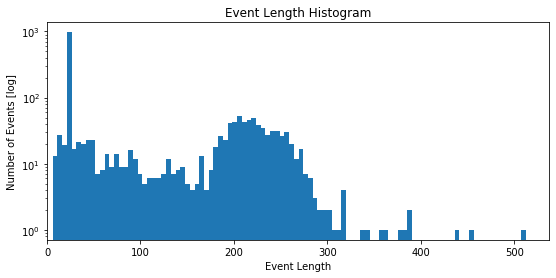

In [4]:
EventLength = []
#Histgram for the event length distribution
for i in range(len(DataList)):
    EventLength.append(len(DataList[i]))
EventLength = np.asarray(EventLength)

# Plot length distribution
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(EventLength, bins = 100)
ax.set_title('Event Length Histogram')
ax.set_xlabel("Event Length")
ax.set_xlim(0,)
ax.set_yscale('log')
ax.set_ylabel("Number of Events [log]")
plt.show()

## Data Splitting

In every ML algorithm we have to first split the data in training, validation and (possibly) test:

- Training Data will be used to "train" the algorithm: fit the model parameters. 
    
- Validation Data are going to be used to see how our algorithm performs on data which has not been used to train it. Anyway, validation data will be use in tuning the model's hyperparameters (e.g. deciding when to stop the training).
            
- Test Data are meant to test the performance of the algorithm on a completely new dataset (unbiased evaluation).
    
The original data is generally divided into training (90% - 70%), and the rest for validation, and testing.
    
Sklearn provides a function: *train_test_split* which makes this operation very handy. This function would split the data in two subsets, in a fraction which is possible to specify through the function arguments. Applying twice this function, we can separate the data in the three subsets: train, validation, and test.
    
In order to save memory, and computation time (because we care a lot about our computers) we do not load the function with actually features and labels, as more obvious choice, but simply with a list of indeces. The outcome of this operation can be viewed as shuffling the indices in three subsets, of desired length.

In [5]:
x_idx = np.arange(len(DataList))

# Splitting in train/validation and test: 90% in train/validation, and 10% test.
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)
# Splitting the remaining part (90% of train/validation): training (90%) and validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was splitted in train, validation, and test:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was splitted in train, validation, and test:
1615 training events,
180  validation events, and
200  test events


# <span style="color:darkred">Data Exploration</span> 

## Visualizing the data: let's get some insight on our dataset!
Now that the data have been preprocessed, we would like to have a first look at the data.  

We plot the first 12 events:
- 3D plots (x,y,z)
- 2D projections (x,y) - the events seen by the pad plane.

### 3D Visualization (x, y, z)

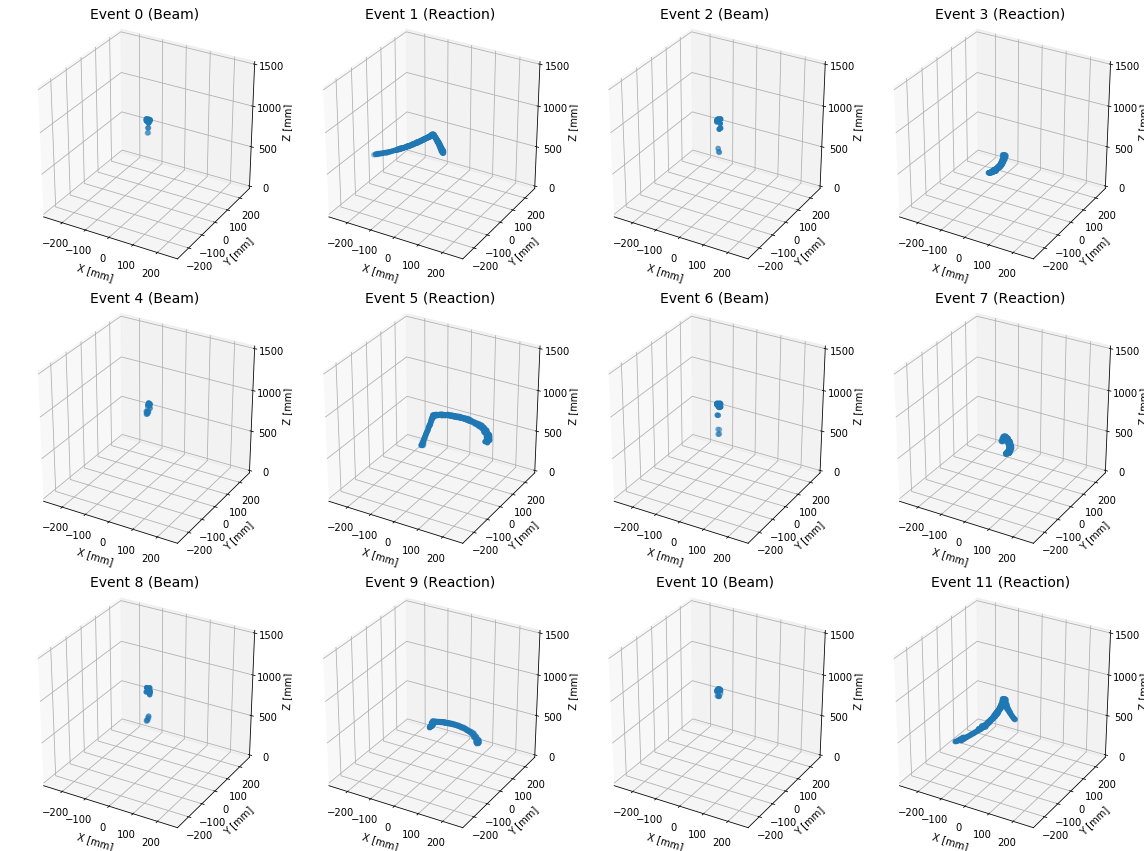

In [6]:
plot_3d_events(DataList,Labels)

### Pad Plane Projections (x, y)
Pad Plane projections of the same 12 events. The gray scale corresponds to the charge deposited on the respective pad (in a logarithmic scale).

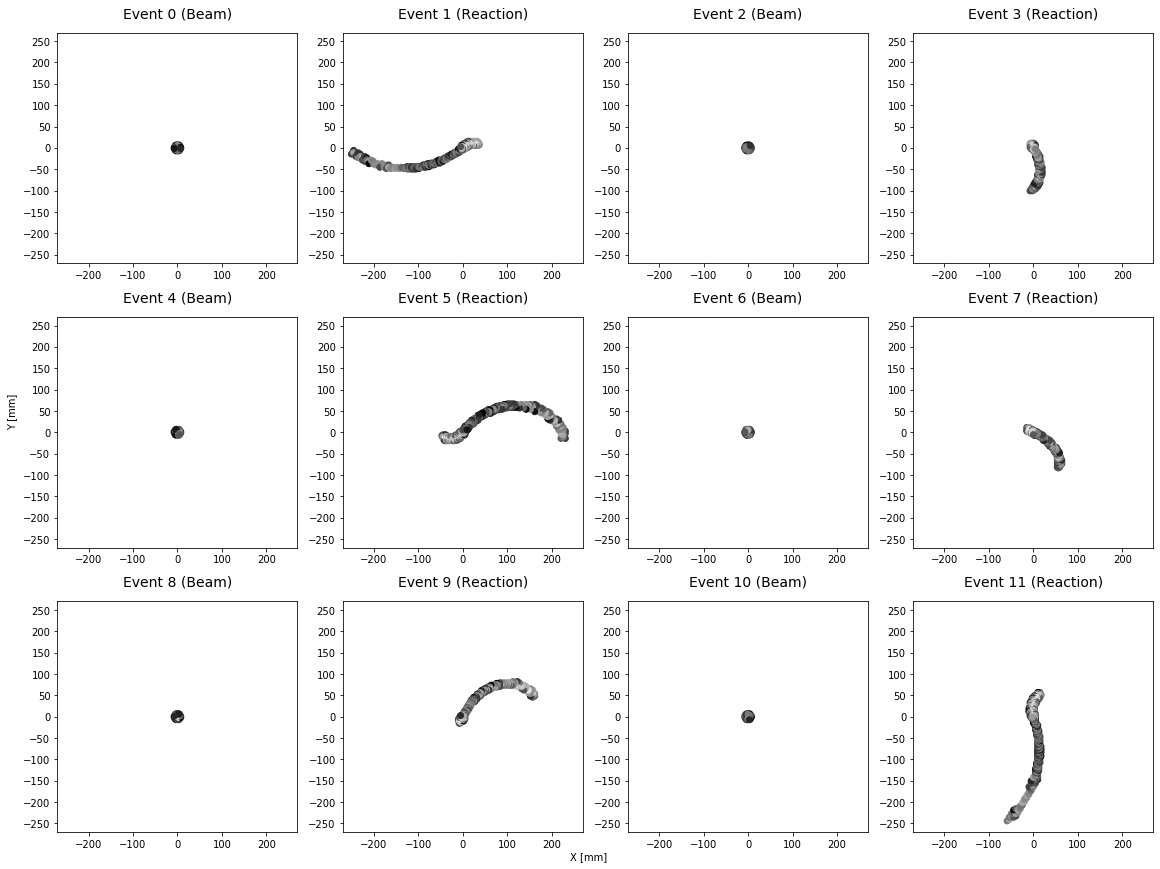

In [7]:
plot_2d_events(DataList, Labels)

##  Feature Selection

Which data do we feed into the algorithm? We cannot use all the 2D matrix containing all the information for each event, we need to see a design matrix, and select relevant only features.  

We extract a certain number of features for each event, based on the information available.  
Which characteristics would help us differentiating beam /reaction events? 


### Features

The question can be answered by looking at the different events: in the plots below, it is quite clear that the number of pads plays a crucial role. Other features may not be obvious, and need a bit of analysis. Most of the times, even by eye we can somehow differentiate the reaction events since they present a more definite and longer track.  

We thought some relevant characteristics could be the average value of x, y and z, or rather a weighted averages, based on the charge deposited, and eventually their standard deviations. Also, the total deposited charge is a fundamental quantity. We also define the quantity FCS (Fraction of Close Pads) which is the ratio of active pads inside a radius of 10 cm (on the (x,y) plane), in respect to the total number of active pads.


Here a list of the quantity we calculate by the function calc_features:
```
# Every quantity is computed for each single event

MeanXPerEvent         # Average X value 
MeanYPerEvent         # Average Y value 
MeanZPerEvent         # Average Z value

MeanWeightedXPerEvent # Charge weighted average X 
MeanWeightedYPerEvent # Charge weighted average Y
MeanWeightedZPerEvent # Charge weighted average Z

StDevXPerEvent        # Standard deviation of X 
StDevYPerEvent        # Standard deviation of Y
StDevZPerEvent        # Standard deviation of Z

SumAPerEvent          # Total deposited charge
PadsPerEvent          # Number of pads fired
FracClosePtsPerEvent  # Fraction of pads inside a circle of radius 10cm to the (x,y)-plane
```


In [8]:
# Computing Features
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)

## Visualizing Features 

In order to visualize the features, and deciding whether are well suited for our task, we provide some plots and histograms below. We immediately notice that some of the extracted features will be more useful, such as the number of active pads, the total charge deposited, and the Mean(Z), while others, like Mean(X) or Mean(Y) are not extremely interesting. 

In [9]:
# Some definition before plotting 
train_r_idx, train_b_idx = train_split(train_idx, Labels)
r_color = 'blue'
b_color = 'black'

### Histograms
- Active Pads per event, 
- Total Deposited Charge per event, and
- Fraction of Active Pads inside a radius of 10 cm.

<a id='Feature_Histograms'></a>

Histograms:


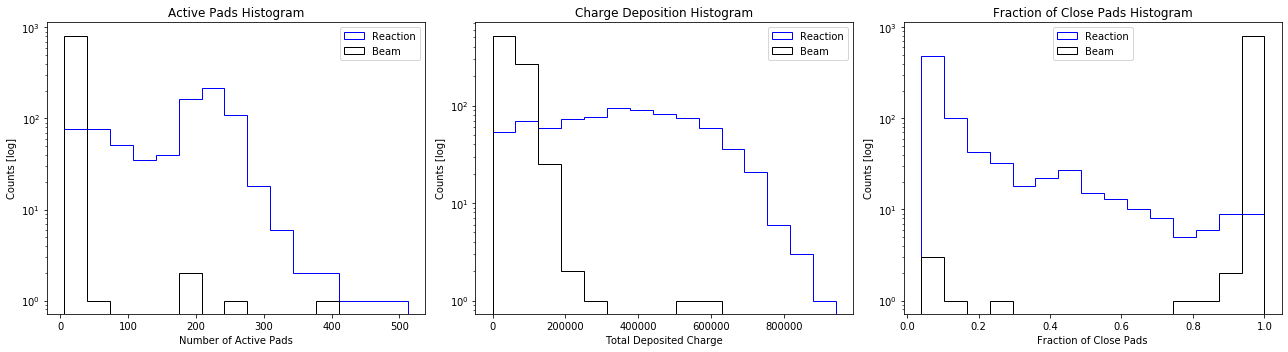

In [10]:
print("Histograms:")
plot_features_hist(train_r_idx, r_color, train_b_idx, b_color, PadsPerEvent, SumAPerEvent, FracClosePtsPerEvent)

Comments:  

- Active Pads Histogram: beam events tend to have a lower amount of active pads.  

- Charge Deposited Histogram: beam events tend to have a lower amount of deposit charge. These two variables can already separate the two types of event rather well.

- Fraction of Close Pads Histogram: this variable represents the fraction of active pads confined in a radius of 10 cm (x,y plane), in relation to all the active pad for that event. It is possible to notice that for beam events this variable approaches the value of 1. Reaction events have a higher dispersion in the x, y (and z) directions (see also stdev plots).  

We notice a few outliers in every histogram: beam events that have characteristics very similar to the reaction ones.

### Scatter Plots

2D Scatter Plots, different combinations are shown:
- Mean (X, Y, Z), and
- Standard Deviation (X, Y, Z).

Scatter Plots: X, Y, Z


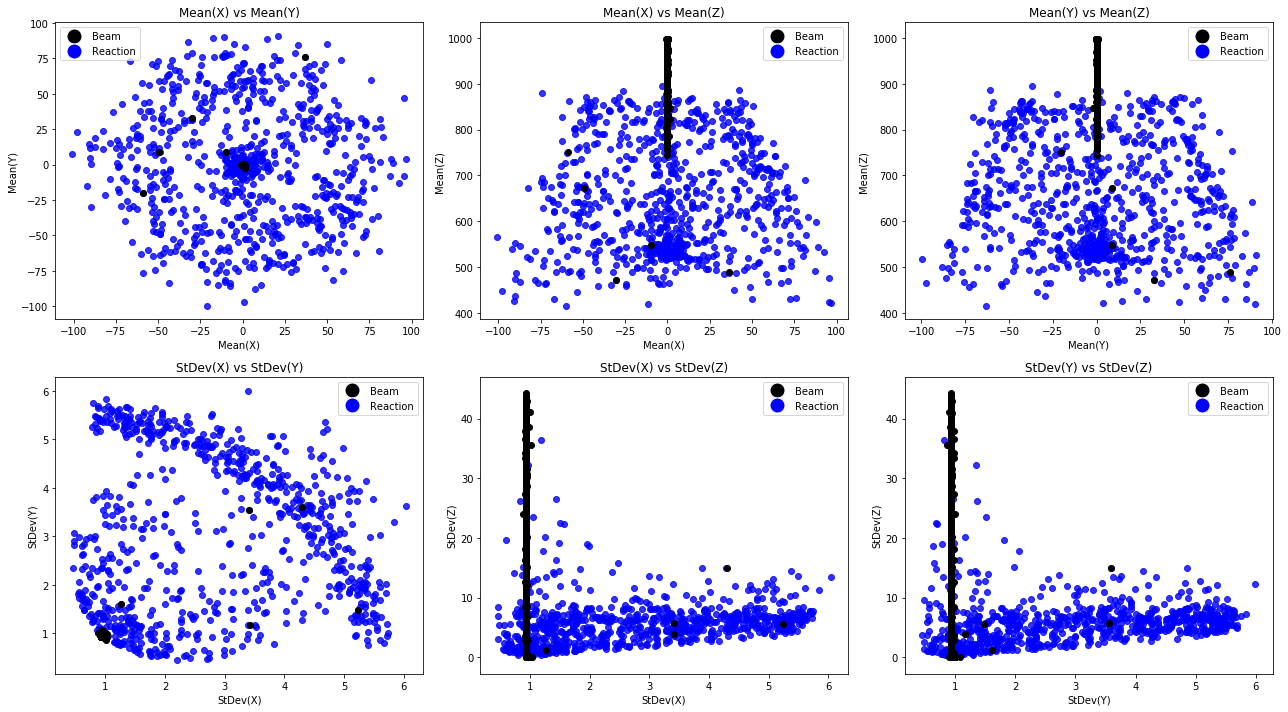

In [11]:
print("Scatter Plots: X, Y, Z")
plot_features_scatter(train_r_idx, r_color, train_b_idx, b_color, MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, StDevXPerEvent, StDevYPerEvent, StDevZPerEvent)

Comments:  

- Mean(X) vs Mean(Y): beam events lay in the center of the plot, while reaction events are scattered with a higher dispersion.   

- Mean(X,Z) and Mean(Y,Z) plots are rather interesting, beam events have generally a larger value of Mean(Z).   

- StDev(X,Y,Z): reaction events have generally a larger spread in the x, and y directions. Conversely, beam events have higher z dispersion, but much smaller for the x, and y directions.  

Again, we notice that there are outliers in every plot. They can not be correctly distinguished using (only) those features.

### Scatter Plots (with most relevant features)
- Stdev(Z) vs FCP
- Active Pads vs Total Deposited Charge

Scatter Plots: Other Combinations


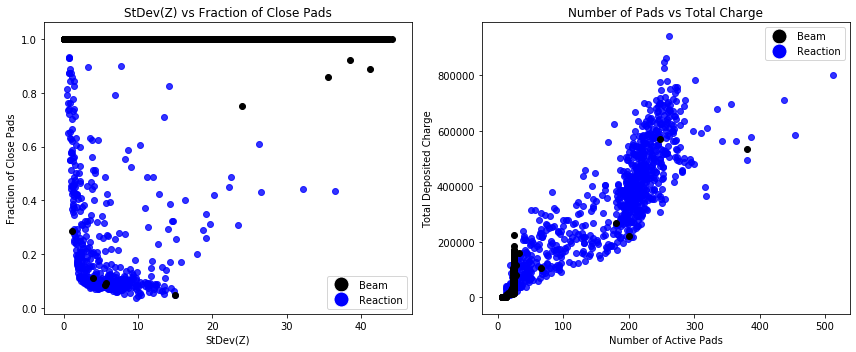

In [12]:
print("Scatter Plots: Other Combinations")
plot_features_scatter2(train_r_idx, r_color, train_b_idx, b_color, StDevZPerEvent, FracClosePtsPerEvent, PadsPerEvent, SumAPerEvent)    

We intended to give a 2D representation of these features, even though the general trend is already well visible in the [Feature Histograms](#Feature_Histograms).

## Visualizing the Outliers

In the plots above, there are some events which label may be mistaken when looking at their features. We plot this events below, together with their features.  
<a id='outliers'></a>

Searching for outliers using following criteria:
stdev(X) >  3  cm      : [ 280  499 1098 1711]
Number of Pads >  100  : [ 280  499 1098 1711]
FCP <  0.4             : [ 280  499 1098 1237 1711]
List of outliers that satisfy at least one criterion: [ 280  499 1098 1237 1711]


>>>>>>>>>>>>>>>>>>>>>>>>>>> Outlier:  280 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  3.411
Number of Pads :  200
FCP            :  9.50%


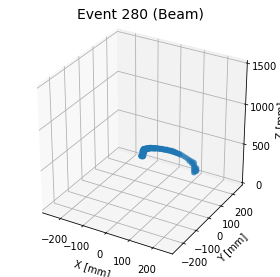

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outlier:  499 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  4.298
Number of Pads :  380
FCP            :  5.00%


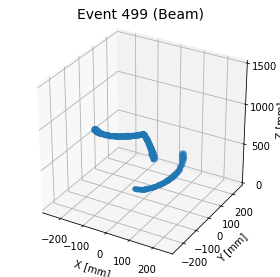

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outlier:  1098 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  3.418
Number of Pads :  180
FCP            :  11.11%


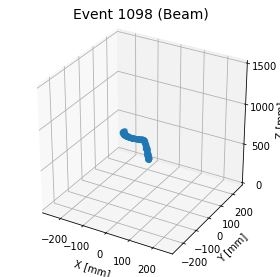

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outlier:  1237 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  1.259
Number of Pads :  66
FCP            :  28.79%


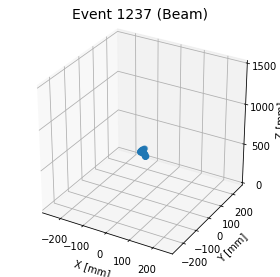

>>>>>>>>>>>>>>>>>>>>>>>>>>> Outlier:  1711 <<<<<<<<<<<<<<<<<<<<<<<<<<<
stdev(X)       :  5.235
Number of Pads :  247
FCP            :  8.50%


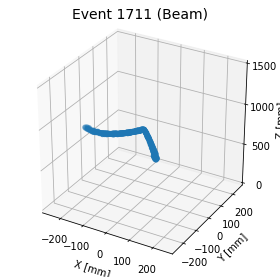

In [13]:
# Outliers Beam events characteristics
plot_beam_outliers(DataList, Labels, train_b_idx, StDevXPerEvent, 3, PadsPerEvent, 100,  FracClosePtsPerEvent, 0.4)

## Design Matrix

Through the plots above, we see that some of the features are clearly useful to classify beam/reaction events. The most meaningful features are used to set a design matrix, we call this matrix X. One may add other features to the design matrix, aiming for better results.

In [14]:
X = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    X[i][0] = MeanZPerEvent[i]
    X[i][1] = StDevXPerEvent[i]
    X[i][2] = FracClosePtsPerEvent[i]
    X[i][3] = SumAPerEvent[i]
    X[i][4] = PadsPerEvent[i]
    # not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
X_train =      X[train_idx][:]
X_val =        X[val_idx][:]
X_test =       X[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val =   Labels[val_idx]
Labels_test =  Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X_df= pd.DataFrame(X)
print("Design Matrix X:")
feature_names = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X_df.columns = feature_names
label_names = ['Beam','Reaction']
display(X_df)

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


## Data Scaling

Scaling (or normalize) the data improve the model performance quite significantly in some cases. Scikit-learn has a few different methods, of which the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) is used below. This scaler transforms each feature such that the scaled features will have mean equal to zero and unit variance. 
<a id='StandardScaler'></a>

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# StandardScaler
X_train_stdsc = scaler.transform(X_train)
X_val_stdsc = scaler.transform(X_val)
X_test_stdsc = scaler.transform(X_test)

# <span style="color:darkred">Machine Learning Algorithms</span> 

After the preliminary operations on the data, we can finally use the *Machine Learning Algorithms*. Different models will be employed, among the ones suited fot the classification task.  

For each model, we give a brief description, we show its performances on our dataset, and we discuss the result obtained.

#  <span style="color:darkred">Logistic regression</span>

Logistic regression is a widely used method for classification. 
It uses a sigmoid function to calculate the probability for an event to belong to a certain class.
The training procedure is used to optimize the cost function in terms of the parameters $\beta$ of the sigmoid function. In our case the standard implementation of [scikit-learn](https://scikit-learn.org/stable/index.html) is used. Remark that this implementation uses L2 regularization by default.    

The print_model_performance function is located in the helper_functions file. It will be used to print the performances and display the confusion matrix for each model: this is done for both training and validation set separately.

##  Logistic Regression: Unscaled Data
This time, we evaluate the model on unscaled features, and later on the scaled ones. We want to show the advantage of using a scaling techniques on the model performances. For the other models in this notebook, only scaled data will be used.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 95.79%
Precision : 99.32%
Recall    : 92.10%
F1-score  : 0.9557
MCC       : 0.9181


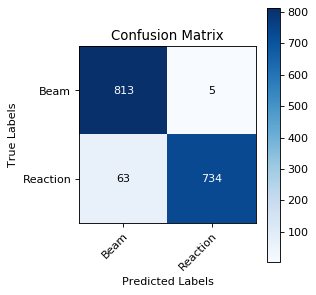


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 96.67%
Precision : 98.86%
Recall    : 94.57%
F1-score  : 0.9667
MCC       : 0.9343


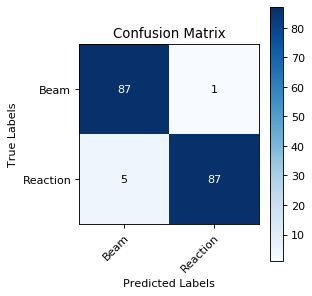

In [16]:
from sklearn.linear_model import LogisticRegression
logreg_unscaled = LogisticRegression()
logreg_unscaled.fit(X_train, Labels_train) # provide Design matrix and labels

LR_unscaled_pred_train = logreg_unscaled.predict(X_train)
LR_unscaled_pred_val = logreg_unscaled.predict(X_val)

# Printing Performances
print_model_performance(Labels_train, LR_unscaled_pred_train, "Training")
print_model_performance(Labels_val, LR_unscaled_pred_val, "Validation")

Not a bad start for our analysis! We reach an accuracy greater than 95% for both training and validation sets, however the model classifies a significant amount of reaction events as beam events.

## Logistic Regression
The logistic regression model is repeated, but the features are now scaled using the [Standard Scaler](#StandardScaler) described above.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


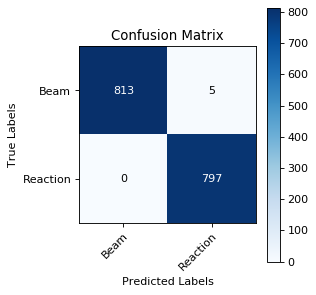


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


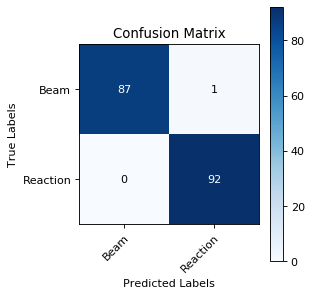

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train_stdsc, Labels_train)

LR_pred_train = logreg.predict(X_train_stdsc)
LR_pred_val = logreg.predict(X_val_stdsc)

# Printing Performances
print_model_performance(Labels_train, LR_pred_train, "Training")
print_model_performance(Labels_val, LR_pred_val, "Validation")

Comparing to previous results (unscaled LR), there is a consistent improvement. This shows it is well worth looking into scaling the features of the dataset.  

The accuracy is above 99% on both training and validation set, the result is already quite impressive: only 5 events are misclassified - which (most likely) correspond to the [5 outliers](#outliers) previously shown.

# <span style="color:darkred">Random Forest</span>

The random forest method combines the output of a certain number of decision trees to make predictions. Each decision tree uses nodes with if-then-else structured conditions on the features that end up in a classification. 

## Decision Tree: an example
Decision trees are a type of model used for both classification and regression. Trees answer sequential yes-no questions which send us down a certain route of the tree depending on the given answers . The model behaves with “if this than that” conditions ultimately yielding a specific prediction. You can see a simple tree displayed below.

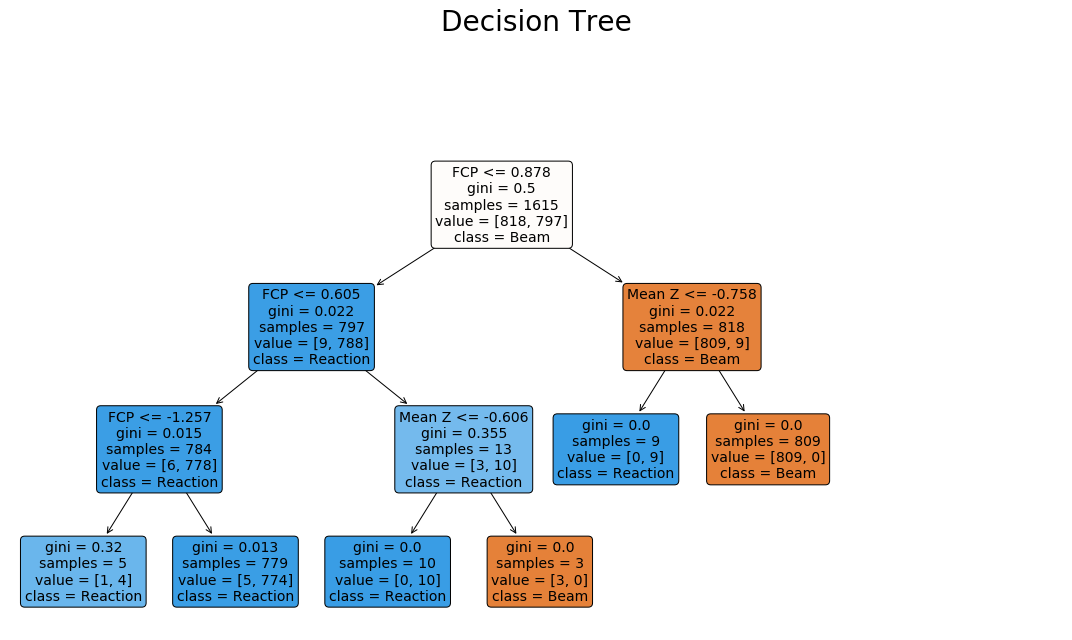

In [18]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(max_depth=3)
DT = DT.fit(X_train_stdsc, Labels_train)

# Better visualization of the tree
fig, ax = plt.subplots(figsize=(15, 9))
tree.plot_tree(DT, fontsize=14, filled = True, rounded = True, feature_names = feature_names, class_names = label_names)
fig.suptitle('Decision Tree', fontsize=28)
fig.tight_layout()
plt.show()

This simple graph shows the steps taken by the decision tree. Each cell contains a condition on one of the features (remember that these are scaled), for example the top cell asks whether $FCP \leq 0.878$. If true, then the left path is followed, else the right path. The 'value' indicates how many events of each type \[beam,reaction\] remain, and 'class' shows the chosen classification at each step. The tree also shows the 'gini' impurity which is used internally for deciding on the conditions of each cell.

##  From Decision Tree to Random Forest  
A random forest is a collection of decision trees whose results are aggregated into one final result. Therefore, random forest is an ensemble method. By averaging over independant results, the variance of the ensemble method is lowered, leading to better results. For more information about ensemble methods, see the [scikit-learn page on ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html).


Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.88%
Precision : 99.75%
Recall    : 100.00%
F1-score  : 0.9987
MCC       : 0.9975


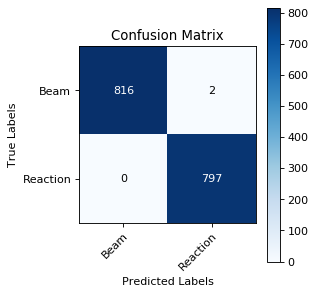


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


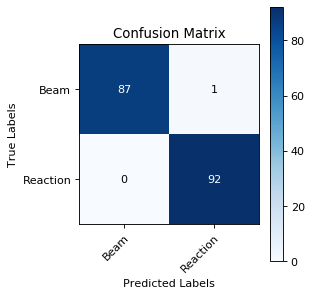

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random forest with n_estimators trees, and usign max_features features
RFC = RandomForestClassifier(n_estimators = 5, max_features = 3)

RFC.fit(X_train_stdsc, Labels_train)

RFC_pred_train = RFC.predict(X_train_stdsc)
RFC_pred_val = RFC.predict(X_val_stdsc)

# Printing Performances
print_model_performance(Labels_train, RFC_pred_train, "Training")
print_model_performance(Labels_val, RFC_pred_val, "Validation")

## Random Forest with Grid Search  
To find the best random forest method, a gridsearch is performed with cross-validation on the training set. 

GridSearchCV is a library function that is a member of sklearn’s model_selection package. It helps to loop through a set of predefined hyperparameters, and fits a model for each setting on the training set. In the end, one can select the best hyperparameters by looking at the best result.

In our case we choose to tune over n_estimators, max_features, and bootstrap. The best estimator is chosen to be the one that maximizes the accuracy on the training set.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid Search, setting parameters
param_grid = [ {'n_estimators': [1,2,3,4,5], 'max_features': [2,3,4,5], 'bootstrap': [False,True]} ]
scoring = 'precision' # 'neg_mean_squared_error', 'accuracy', 'recall'

# Perform Grid Search on RFC
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring=scoring)
# Loop on RFC for different hyper-parameters
grid_search_imp.fit(X_train_stdsc, Labels_train)
cvres = grid_search_imp.cv_results_
# Calculate Feature Importances
feature_importances = grid_search_imp.best_estimator_.feature_importances_

# Printing Result Found through Grid Search
print("GridSearch on RFC: Tuning hyper-parameters for %s." % scoring)
print("----------------------------------------------------------")
print(">>> Best Parameters set:\n", grid_search_imp.best_params_)
print("")
print(">>> Best Estimator:\n",grid_search_imp.best_estimator_)
print("")
print(">>> Feature Importances: ")
fi_list = list(sorted(zip(np.round(feature_importances,3), feature_names), reverse=True))
print(fi_list[:])
print("")

# Revome comments signs below to show performance for each set of hyperparameters.
#print(">>> Results for each set of parameters:")
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print("Mean score: {:.2f}%".format(mean_score*100), params)

GridSearch on RFC: Tuning hyper-parameters for precision.
----------------------------------------------------------
>>> Best Parameters set:
 {'bootstrap': True, 'max_features': 2, 'n_estimators': 1}

>>> Best Estimator:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

>>> Feature Importances: 
[(0.961, 'FCP'), (0.025, 'Total Q'), (0.011, 'stdev(X)'), (0.003, 'Pads'), (0.0, 'Mean Z')]



Model performance for Training set:
--------------------------------------------------------
Accuracy  : 100.00%
Precision : 100.00%
Recall    : 100.00%
F1-score  : 1.0000
MCC       : 1.0000


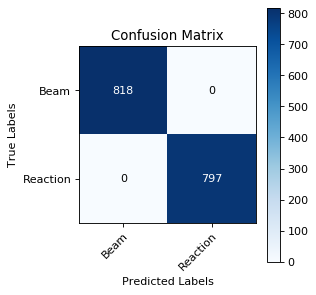


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 98.89%
Precision : 98.91%
Recall    : 98.91%
F1-score  : 0.9891
MCC       : 0.9778


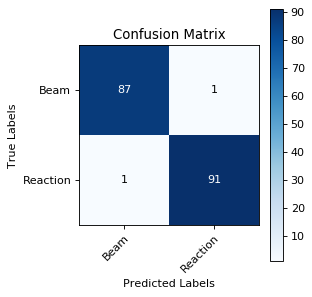

In [21]:
RFC_GS = grid_search_imp.best_estimator_
RFC_GS_pred_train = RFC_GS.predict(X_train_stdsc)
RFC_GS_pred_val = RFC_GS.predict(X_val_stdsc)

# Printing Performances
print_model_performance(Labels_train, RFC_GS_pred_train, "Training")
print_model_performance(Labels_val, RFC_GS_pred_val, "Validation")

The best random forest estimator (found by grid search) reaches an accuracy of over 99% on both training and validation set. Its results are very similar to the ones from the logistic regression. It seems that the random forest estimator does overfit slightly, given its larger accuracy on the training set (compared to the validation set), but the limited size of the dataset makes it harder to draw firm conclusions. In case it does, one could also restrict the 'max_depth' parameter of the trees to reduce overfitting.  

Note: the result of this model may slightly differ every time you run the notebook.

#  <span style="color:darkred">Dense Neural Network</span> 
The next model is a dense neural network (DNN). In this network the features act as input nodes. These are connected to neurons in a hidden layer, which have weights and biases. Based on their activation function and the inputs each neuron calculates an output as input for the next layer. When the output layer is reached the results are compared to the labels. By using backpropagation the weights and biases are updated in order to improve the correspondance of labels and output.

## Setting the DNN

There are quite some parameters that can be tuned for a DNN, including number of hidden layers, number of neurons per layer, type of activation function, using batch normalization or dropout, which optimizer to use, etc. No attempt is made to try all combinations. After varying the number of layers, adding or removing batch normalization and changing the number of nodes in the dense layers, the model below was found to perform well. Its relative simplicity ensures fast training of the neural network.

In [22]:
# Init the Sequential model
DNN_model = tf.keras.Sequential()
# Add Input layer
DNN_model.add(tf.keras.layers.InputLayer(input_shape=(X_train_stdsc.shape[1],)))
# Add hidden layer
DNN_model.add(tf.keras.layers.Dense(64, activation='relu'))
DNN_model.add(tf.keras.layers.BatchNormalization())
DNN_model.add(tf.keras.layers.Dense(64, activation='relu'))


# Add output layer.
DNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
DNN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
DNN_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,737
Non-trainable params: 128
_________________________________________________________________


The number of epochs and the size of the mini batches for training is set.

In [23]:
# Set parameters for the training run. The full data set is only 2000x5 doubles so large nr of epochs and
# small batch_size will still work well even on cpu
epochs = 20
batch_size = 16

## Training the DNN
The DNN is fitted on the training set. The performance on the validation set is also shown in the output. It should not take long to complete.

In [24]:
DNN_history = DNN_model.fit(
    x=X_train_stdsc,
    y=Labels_train,
    validation_data=(X_val_stdsc, Labels_val),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 1615 samples, validate on 180 samples
Epoch 1/20
1615/1615 [==============================] - 0s 227us/sample - loss: 0.1091 - acc: 0.9641 - val_loss: 0.1574 - val_acc: 0.9944
Epoch 2/20
1615/1615 [==============================] - 0s 98us/sample - loss: 0.0267 - acc: 0.9963 - val_loss: 0.0692 - val_acc: 0.9944
Epoch 3/20
1615/1615 [==============================] - 0s 91us/sample - loss: 0.0195 - acc: 0.9963 - val_loss: 0.0374 - val_acc: 0.9944
Epoch 4/20
1615/1615 [==============================] - 0s 91us/sample - loss: 0.0263 - acc: 0.9969 - val_loss: 0.0337 - val_acc: 0.9944
Epoch 5/20
1615/1615 [==============================] - 0s 90us/sample - loss: 0.0231 - acc: 0.9963 - val_loss: 0.0399 - val_acc: 0.9944
Epoch 6/20
1615/1615 [==============================] - 0s 107us/sample - loss: 0.0215 - acc: 0.9969 - val_loss: 0.0389 - val_acc: 0.9944
Epoch 7/20
1615/1615 [==============================] - 0s 92us/sample - loss: 0.0210 - acc: 0.9969 - val_loss: 0.0403 - val_acc:

The training history of the model is shown.

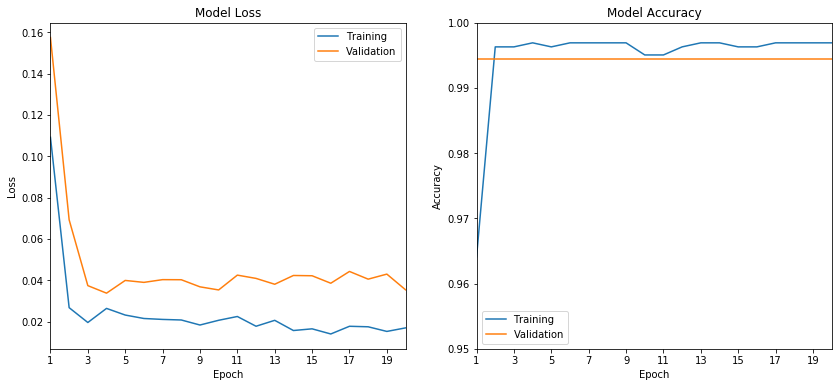

In [25]:
# Model History
make_nn_plots(DNN_history)

From the model history one can see it is not necessary to increase the number of epochs, as its performance is stable after just a few epochs.  

After training the DNN, the predictions are created and the model performance is printed.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


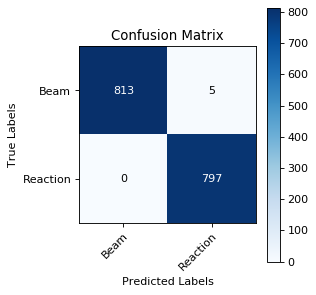


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


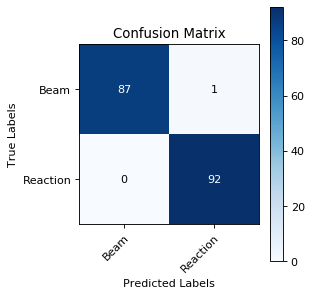

In [26]:
#The predictions contain a number in [0,1] these get mapped to 1 if >0.5 and to 0 if <0.5
#This way a hard classifier is created
DNN_pred_train_pre = DNN_model.predict(X_train_stdsc)
DNN_pred_val_pre = DNN_model.predict(X_val_stdsc)
DNN_pred_train = DNN_pred_train_pre > 0.5
DNN_pred_val = DNN_pred_val_pre > 0.5

# Printing Performances
print_model_performance(Labels_train, DNN_pred_train, "Training")
print_model_performance(Labels_val, DNN_pred_val, "Validation")

The DNN performs rather well, and its predictions are consistent with the logistic regression method. It is worth noticing we still see the same [5 outliers](#outliers).

#  <span style="color:darkred">K-Means</span> 
K-Means (KM) is a method that tries to identify, and separate clusters in the dataset.
One main difference in respect to the other methods already used is that KM is an unsupervised learning method (it does not use the labels). Nevertheless, one can still try to assign each KM-cluster to a class, and see what are the results.

## Elbow method for K-Means
One parameter KM requires is the number of clusters to search for. An obvious choice would be to take the number of clusters equal to the number of classes in the dataset (two). Anyway, there exists a way to look for the optimal number of clusters, called the elbow method. The KM method tries to minimize the 'inertia', which is the sum of squared error inside a cluster. However, we cannot look for the minima of this in function of the number of clusters, as more clusters always reduce the inertia. Therefore, one looks for the 'elbow' of this plot, the number of clusters at which the inertia is lowered significantly, which results in a kink in the curve (which resembles an elbow).
This approach is based on [Geron's notebook](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)
        (search for 'finding the optimal number of clusters').

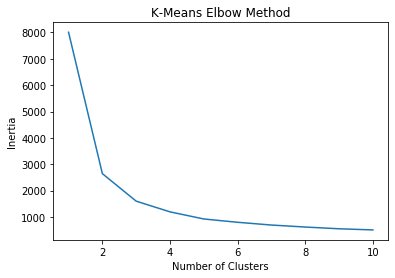

In [27]:
# Calculating Inertia for each K-Means with different number of clusters
from sklearn.cluster import KMeans
nr_clusters = range(1,11)
inertia = []

for k in nr_clusters:
    km = KMeans(n_clusters=k)
    km.fit(X_train_stdsc)
    inertia.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') 
plt.title('K-Means Elbow Method')
plt.plot(nr_clusters,inertia)

fig.tight_layout()
plt.show()

From the figure above it seems there are two suitable candidates for the optimal number of clusters $k \in [2,3]$.

Fitting KM for these two cases is straightforward, however the cluster predictions still need to be mapped to class predictions. This means assigning a KM cluster to either beam or reaction events. KM itself does not tell us how to 
map these, so the best mapping is defined as the one that gives the highest accuracy (the function best_cl_km has been designed to perform this task). To do so, the accuracies are determined for all possible mappings, excluding the trivial ones that map all clusters to the same class.

##  2 clusters K-Means

In the $k=2$ case finding the best mapping is quite straightforward, with only two useful mappings.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 91.02%
Precision : 99.39%
Recall    : 82.31%
F1-score  : 0.9005
MCC       : 0.8321


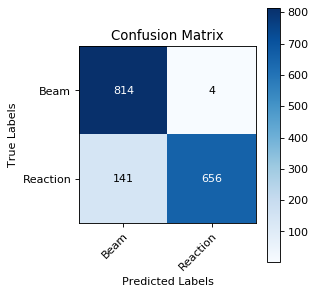


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 91.67%
Precision : 98.73%
Recall    : 84.78%
F1-score  : 0.9123
MCC       : 0.8426


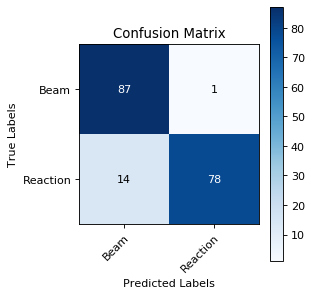

In [28]:
KM_clust2 = KMeans(n_clusters=2).fit(X_train_stdsc)

KM2_pred_train = KM_clust2.predict(X_train_stdsc)
KM2_pred_val = KM_clust2.predict(X_val_stdsc)

#Now we need to find out which cluster is which type of event
#We select the one that gives best accuracy on training set

accuracy_train_norm = accuracy_score(Labels_train, KM2_pred_train) 
accuracy_train_swap = accuracy_score(Labels_train, 1-KM2_pred_train) # swap label assigned

# Accuracy may improve when swapping the labels, in that case use swapped labels
if(accuracy_train_swap>accuracy_train_norm):
    KM2_pred_train = 1- KM2_pred_train
    KM2_pred_val = 1 - KM2_pred_val

# Printing performances
print_model_performance(Labels_train,KM2_pred_train,"Training")
print_model_performance(Labels_val,KM2_pred_val,"Validation")

## 3 clusters K-Means

In the $k=3$ case finding the best mapping involves trying all the possibilities. For brevity of the report, 
the determination of the best mapping has been moved to the helper functions.

KMeans with 3 clusters performance:
Max accuracy obtained is 0.9963  using the combination number : 3
Combination 3 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0), (2, 1.0)]
----------------------------------------------------------
Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.63%
Precision : 99.38%
Recall    : 99.87%
F1-score  : 0.9962
MCC       : 0.9926


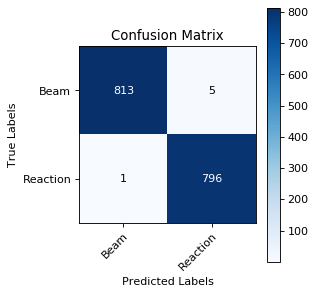


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


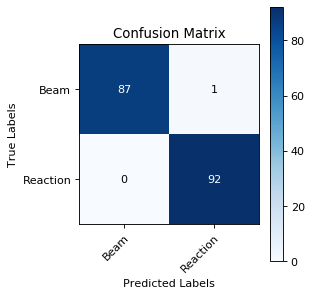

In [29]:
KM_clust3 = KMeans(n_clusters=3).fit(X_train_stdsc)

# Using function best_3cl_km in helper_function.py
KM3_pred_train, KM3_pred_val, assoc = best_cl_km(3, KM_clust3, X_train_stdsc, X_val_stdsc, Labels_train)

# Printing performances
print_model_performance(Labels_train,KM3_pred_train,"Training")
print_model_performance(Labels_val,KM3_pred_val,"Validation")

Comparing the results of 2 and 3-cluster K-Means, it is clear that the 3-clusters model performs better. One should be careful not to use too many clusters because at some point it will lead to overfitting, but here this is not the case. K-Means performancies are comparable with the previous models.

#  <span style="color:darkred">Support Vector Machine</span> 

Next, a support vector machine is used for classification. This method uses kernel functions (e.g. polynomial, radial basis function ...) in order to perform a mapping of the input data in an higher dimensional space. This procedure would make the classification task easier since data points in the original space may not be linearly separable. It is important to notice that this high-dimensional feature space is hidden both from the input, and output (same logic as the DNN hidden layer).  

After this remapping phase, the algorithms finds a proper set of hyperplanes by maximizing the distance to the training data point. We use grid search on different kernel functions to find an optimal model.  

For information on the different kernels and their parameters, see the [scikit-learn page on SVM](https://scikit-learn.org/stable/modules/svm.html).

In [48]:
from sklearn.metrics import classification_report
from sklearn import svm


#Using grid search
#Select optimal parameters by cross-validation

# Set of tuning parameters
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2,3,4], 'coef0': [0.,0.01,0.1,0.5,1.5]},
                   {'kernel': ['sigmoid'], 'C': [1, 10, 100, 1000], 'coef0': [0.,0.01,0.1,0.5,1.5]}]

# Select a metric to select best SVM (comment one or the other)
score = 'recall' #'precision'

SVM = GridSearchCV(
    svm.SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)

SVM.fit(X_train_stdsc,Labels_train)
cvres_SVM = SVM.cv_results_

print("GridSearch on SVC: Tuning hyper-parameters for %s." % score)
print("----------------------------------------------------------")
print(">>> Best Parameters set:\n", SVM.best_params_)
print("")
print(">>> Best Estimator:\n",SVM.best_estimator_)
print("")

# Revome comments signs below to show performance for each set of hyperparameters.
#print(">>> Results for each set of parameters:")
#for mean_score, std, params in zip(cvres_SVM["mean_test_score"], cvres_SVM["std_test_score"], cvres_SVM["params"]):
#    print("Mean score: %0.3f +/- %0.03f for parameters set: %r" % (mean_score, std * 2, params))

GridSearch on SVC: Tuning hyper-parameters for recall.
----------------------------------------------------------
>>> Best Parameters set:
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

>>> Best Estimator:
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



Model performance for training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


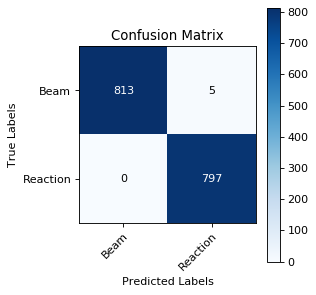


Model performance for validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


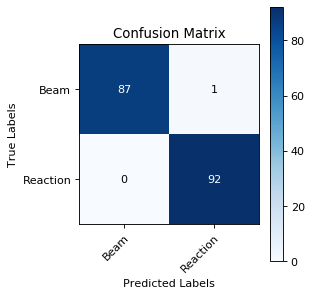

In [49]:
SVM_pred_train = SVM.predict(X_train_stdsc)
SVM_pred_val = SVM.predict(X_val_stdsc)

# Printing performances
print_model_performance(Labels_train, SVM_pred_train, "training")
print_model_performance(Labels_val, SVM_pred_val, "validation")

This model also performs well on both training and validation set. In fact, it gives the same predictions as the DNN model and the logistic regression (using scaled data).

#  <span style="color:darkred">Voting Classifier</span> 

A voting classifier is a way to combine the predictions of multiple models into one prediction. Here, a simple voting approach is used. Each model prediction is counted as a vote for one of the two classes (beam or reaction). The class gaining the majority of the votes is selected. It is hoped that this voting classifier improves the performance of the individual models. 

In our implementation a model votes one if it classifies the event as a reaction event, and zero otherwise. These votes are added. Five models are used: Logistic Regression (using standardscaled data), Random Forest, DNN, 3-cluster K-Means, and Support Vector Machine. If the sum of votes exceeds half the number of models, this means at least three models voted for reaction, the voting classifier selects reaction, if not it selects beam.

<a id='VotingClassifier'></a>

In [50]:
Vote_pred_train = np.zeros(len(DNN_pred_train))
Vote_pred_val = np.zeros(len(DNN_pred_val))

total_vote_train = np.zeros(len(DNN_pred_train))
total_vote_val = np.zeros(len(DNN_pred_val))

# Vote on Training Set
for i in range(len(DNN_pred_train)):
    TotalVotesTrain = DNN_pred_train[i] + KM3_pred_train[i] + LR_pred_train[i] + RFC_GS_pred_train[i] + SVM_pred_train[i]
    total_vote_train[i] = TotalVotesTrain
    
    if TotalVotesTrain > 2.5:
        Vote_pred_train[i] = 1
    else:
        Vote_pred_train[i] = 0
                
# Vote on Validation Set
for i in range(len(DNN_pred_val)):
    TotalVotesVal = DNN_pred_val[i] + KM3_pred_val[i] + LR_pred_val[i] + RFC_GS_pred_val[i] + SVM_pred_val[i]
    total_vote_val[i] = TotalVotesVal
    
    if TotalVotesVal > 2.5:
        Vote_pred_val[i] = 1
    else:
        Vote_pred_val[i] = 0

Model performance for training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


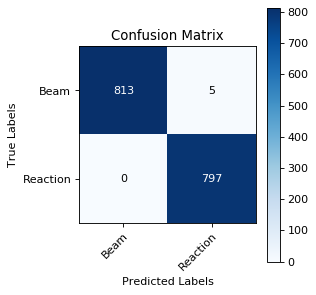


Model performance for validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


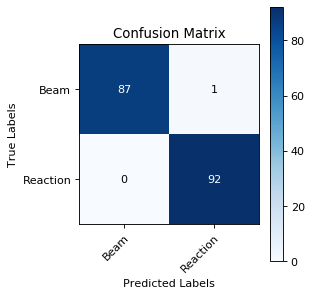

In [51]:
print_model_performance(Labels_train, Vote_pred_train, "training")
print_model_performance(Labels_val, Vote_pred_val, "validation")

The voting classifier obtains good results, but does not represent an improvement 
over the individual models. However, this does not come as a surprise. As noted above, three of the models
(logistic regression, DNN and SVM) yield the same predictions. The voting classifier follows their decisions
because together these models form the majority of the models.

# <span style="color:darkred">Convolutional Neural Network

"Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. In the last few years, thanks to the increase in computational power, the amount of available training data, \[...\] CNNs have managed to achieve superhuman performance on some complex visual tasks. They power image search services, self-driving cars, automatic video classification systems, and more. Moreover, CNNs are not restricted to visual perception: they are also successful at other tasks, such as voice recognition or natural language processing (NLP)."  

\[*Hands-On Machine Learning with Scikit-Learnand TensorFlow*, Aurélien Géron \]  

Convolutional neural network (ConvNets or CNNs) is one of the main categories to do images recognition, images classifications. Convolutional networks are similar to neural networks, but they use convolution in place of general matrix multiplication in (at least) one of their layers.

The first part of this section would be dedicated to the conversion of our events into images, the input of the CNN model. The remaining part, would deal with the CNN algorithm itself: setting/training the model and evaluating its performances. Two CNN models are used: a user-defined one, and the [VGG16](https://neurohive.io/en/popular-networks/vgg16/).


## Generating the Images
This is how an event looks like: 
```
DataList[0]:
array([(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0),
       (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0),
       (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0),
       (...
       (-7.36236525e+00, -1.45075214, 998., 499, 1.74805170e+01, 0)]
```

We want to convert this in a 2D image, to use for the CNN algorithm. 

The first thought is to use the the (x,y) projection: we will pixel the surface in order to save it as a 2D matrix.
We would like that every pad correspond to a matrix element, or at least that every matrix element is associated to the same number of pads.

Once the 2D matrix is prepared, we need to fill the image with the pixel values: the best choice is to use the charge deposited on that pad as pixel value. We will use 1/0 ("fired/not fired"), since it represents a good check for bugs, and a good way of visualizing the data.

With the images produced we will feed the CNN algorithm, and evaluate the perormances.

### Preparing the data
We first store teh data in a convenient format.

In [ ]:
# Generate arrays to perform math operations
points, xy_values = prepare_images_data(DataList)

###  Pad Plane Dimenstion
We can extract the dimension of the image we want to create, based on the max/min values of the (x,y)-tuple.
We will assume the pad plane is squared.
The information concerning the pad plane will be printed below.

In [ ]:
x_max = np.amax(xy_values[:,0])
x_min = np.amin(xy_values[:,0])  
y_max = np.amax(xy_values[:,1])
y_min = np.amin(xy_values[:,1])
x_uniques = np.unique(np.around(xy_values[:,0],3))
y_uniques = np.unique(np.around(xy_values[:,1],3))

print("PAD PLANE Dimensions: ")
print("")
print("X range: ", (round(x_max,2), round(x_min,2)))
print("Y range: ", (round(y_max,2), round(y_min,2)))
print("")

# Show (some) discrete values that x and y can assume...
print("Possible positive values of x: ")
print(x_uniques[x_uniques>0][0:10], " and so on...")
print("Possible positive values of y: ")
print(y_uniques[y_uniques>0][0:10], " and so on...")

We can see that the (x,y)-tuple assume only discete values (as expected, since we have a discrete number of pads). The positions of the tuple correspond at the center of the corresponding pad.

### Pad Plane Visualization
In order to genereate a proper matrix, we first need how to set the grid on the (x,y) place. The exercise does not give us the dimension of the single pads, but we can figure it out.
Plotting the superposition of all the events, we can visualize the pad plane structure.

In [ ]:
print("Pad Plane: Superposition of all Events")
plot_pad_plane(xy_values)

We deduce different things from thess images:
- The simulated events seems to span all over the pad plane, as should be.
- The singlepad plane shape is triagular, and we can calculate the exact dimension.
- The pad plane does not have the same dimension, but in the most peripheral region, the pads become bigger (but remain triangular).

We can visualize even a single event to see which pads fired:

In [ ]:
print("Plotting Event_1 Fired Pads:")
fig, ax = plt.subplots( figsize=(6, 4))
xy_event_1 = get_xy_event(points, 1)

ax.set_title("Event 1 (Reaction Event)")
ax.scatter(xy_event_1[:,0],xy_event_1[:,1], c = "black", alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")    
ax.set_xticks(np.arange(-250, +251, 50))
ax.set_yticks(np.arange(-250, +251, 50))
ax.set_xlim(-270,+270)
ax.set_ylim(-270,+270)

fig.tight_layout()
plt.show()

### Setting the 2D Matrix
From the previous plot, in particular the one of the Pad Plane structure close to the origin, we can start thinkin ga good way in order to "pixel/grid" our surface.

We divide the surface in little squared pixels, computing manually the spacing among each pad, both in x, and in y direction. It requires a bit of work, in order to etract the proper values.

Some of these numbers have been obtain looking studying the grid, extracting values based on geometric consideration, and using these value in order to compute the grid spacing with a good precision, that's why some numerical values appear "hard coded". I am aware the cell above looks quite ugly, anyway form the plots that follow it is possible to check that the calculation is correct. 

In [ ]:
#Calculate with better precision
x_temp = np.unique(np.around(xy_values[:,0],5))
y_temp = np.unique(np.around(xy_values[:,1],5))


# X - spacing calculation
print("Calculatig X-spacing")
print("--------------------------------------------------")
print("Showing last x values: ", x_temp[-4:])
print("Approximate number of cells: ", x_temp[-1]/2.454) #2.454 is the approximate spacing
nxc = int(round(x_temp[-1]/2.454))
print("Correct number of cells: ", nxc)
x_spc = x_temp[-1]/nxc # this is the spacing calculated more accurately
print("So that the corret spacing is ", x_spc)
x_shift = x_spc/2
print("")
# Y - spacing calculation
print("Calculatig X-spacing")
print("--------------------------------------------------")
print("Last y values: ", y_temp[-4:])
#print(y_temp[-30:-20]) # here you can find the value of 134.57027
print("Approximate number of exagons:", (134.57027+1.4508)/(7.0506+1.4508))
nyex = int(round((134.57027+1.4508)/(7.0506+1.4508)))
print("Correct number of exagons: ", nyex)
y_spc = (134.57+1.4508)/(nyex*4)
print("The corret spacing is ", y_spc)
y_shift = 0

#y_spc = 2.1422616225
#y_shift = 0

#### Plotting the Grid
This function will show the grid parameters, and plot the grid. It is possible to check whether it corresponds to the desired result.

In [ ]:
show_grid(xy_values, x_max, y_max, x_spc, y_spc, x_shift, y_shift)

### Improved Grid
We do not like that many pads will have for sure no charge, since they do not contain any points. We try to merge four pads together, and use the new grid as show below. This grid guarantees that each pixel contain the same amount of pad (i.e. 2 pads per pixel).

In [ ]:
x_grid = x_spc*2
y_grid = y_spc*2
x_shift_grid = x_grid/4
y_shift_grid = 0

show_grid(xy_values, x_max, y_min, x_grid, y_grid, x_shift_grid, y_shift_grid)

### Images
We will generate two different type of images:
- images: pixel value is equal to charge deposited.
- images_pads: pixel value is the number of time that pixel fired during the event.

The choice that carries more physical meaning is to have the image pixels filled with the respective charge deposited, but also plotting the images of pad "fired/not fired" is pretty interesting.

First, we define the pixel values accordingly, then we assign it to the proper matrix element.


In [ ]:
Q = []
pads = []

for i in range(len(points)): # loop on event number
    Q.append([])
    pads.append([])
    for j in range(len(points[i])): # loop on event rows
        Q[i].append(math.log(DataList[i][j][4])) 
        pads[i].append(1)

images = generate_images(points, Q, x_max, y_max, x_grid, y_grid, x_shift_grid, y_shift_grid)
images_pads = generate_images(points, pads, x_max, y_max, x_grid, y_grid, x_shift_grid, y_shift_grid)

### Image Manipulation

#### Image Reduction

We want to reduce the dimension to limit the time to run the model. Also, most of the information is contained in the center of the pad plane, so we ""throw away" the most peripher pixels.

In [ ]:
# Working with reduced images
images_red = reduce_images_dim(images, 40)
images_pads_red = reduce_images_dim(images_pads, 40)


#### Image Compression
In order to compute faster, we will make the picture more "blurred", converting block of 4 pixels into 1. The image will reduce significatively.

Edit: We decided to not use this step in order to increase accuracy

In [ ]:
images_red_merged = merge_pixels(images_red, 2, 2)
images_pads_red_merged = merge_pixels(images_pads_red, 2, 2)

#### Image Normalization
Last step is to normalize the images, we use the range (0,255) only integer.  

In [ ]:
images_processed= normalize_image_data(images_red)
images_pads_processed= normalize_image_data(images_pads_red)

### Image Visualization
We use this function in order to plot the images obtained after the "pre-processing" phase.
We will plot the two type of images: 
- pixel values = fired/not fired,
- pixel values = log(Q) (deposited charge in log scale).

#### Difference in the two types of images

In [ ]:
print("Printing Images Pads")
plot_images(images_pads_processed, Labels,0, 1)
print("Printing Images Q")
plot_images(images_processed, Labels,0, 1)
#plot_images(images_ML_pads, Labels)

#### Plotting images based on charge deposited

In [ ]:
plot_images(images_processed, Labels,0, 3)

## CNN: The algorithm

At this point we have converted the event, into images, we can start setting the CNN algorithm.  
The last step is to split the images in train/val images split, in the same way we did before for the previous models.

In [ ]:
from tensorflow.keras.utils import to_categorical

images_ML = np.reshape(images_processed, (images_processed.shape[0], images_processed.shape[1], images_processed.shape[2], 1)) # image, x, y, ch

images_train = images_ML[train_idx]
images_val = images_ML[val_idx]
images_test = images_ML[test_idx]

Labels2_train = to_categorical(Labels_train)
Labels2_val   = to_categorical(Labels_val)
Labels2_test  = to_categorical(Labels_test)

### Setting the CNN
Defining my CNN model.  

In [ ]:
my_model = tf.keras.Sequential()

my_model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(10, 10),
        activation='relu',
        padding='same',
        input_shape=images_ML.shape[1:] # Shape of a single imag
                                )
        )

my_model.add(BatchNormalization())

my_model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
my_model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
my_model.add(tf.keras.layers.Flatten())
my_model.add(tf.keras.layers.Dense(40, activation='relu'))
my_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Once the model is defined, we need to compile it. 
# This is where we specify the loss function, optimizer, and metrics if we want.
my_model.compile(
    tf.keras.optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.9),
    loss='binary_crossentropy', #'sparse_categorical_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

In [ ]:
history = my_model.fit(images_train,
          Labels_train,
          batch_size=128,
          epochs=10,
          validation_data=(images_val, Labels_val));

In [ ]:
make_nn_plots(history,0.95)

In [ ]:
CNN_pred_train_pre = my_model.predict(images_train)
CNN_pred_val_pre = my_model.predict(images_val)
CNN_pred_train = CNN_pred_train_pre > 0.5
CNN_pred_val = CNN_pred_val_pre > 0.5
print_model_performance(Labels_train, CNN_pred_train, "Training")
print_model_performance(Labels_val, CNN_pred_val, "Validation")

### VGG 
Importing a pre-trained VGG model.  

In [ ]:
images_train_3d = np.expand_dims(images_train,3)
images_train_VGG = np.repeat(images_train,3,3)

images_val_3d = np.expand_dims(images_val,3)
images_val_VGG = np.repeat(images_val,3,3)

In [ ]:
model = build_pretrained_vgg_model((images_train_VGG.shape[1],images_train_VGG.shape[2],3), 2)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_VGG = model.fit(images_train_VGG,
          Labels_train,
          batch_size=32,
          epochs=10,
          validation_data=(images_val_VGG, Labels_val));

In [ ]:
make_nn_plots(history_VGG,0.95)

In [ ]:
VGG_pred_train_pre = model.predict(images_train_VGG)
VGG_pred_val_pre = model.predict(images_val_VGG)
VGG_pred_train = VGG_pred_train_pre > 0.5
VGG_pred_val = VGG_pred_val_pre > 0.5
print_model_performance(Labels_train, VGG_pred_train, "Training")
print_model_performance(Labels_val, VGG_pred_val, "Validation")

#  <span style="color:darkred">Dimensionality Reduction</span> 

Dimensionality reduction means transforming the feature set to a lower-dimensional space. This is done to 
speed up training of models by reducing the number of features. In addition it also allows for a 
2d visualization of the dataset (if the feature set is reduced to two dimensions). In this section two methods for dimensionality reduction are discussed, namely PCA and t-SNE. These are applied to reduce the five-dimensional feature set above to a new two-dimensional representation.

## Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is an often used method. It works by finding the hyperplane closest 
to the datapoints and subsequently projects the datapoints on this hyperplane. The two dimensions of the hyperplane 
give rise to a new 2d coordinate ($x_1$,$x_2$) for each datapoint. The PCA method is implemented in scikit-learn.

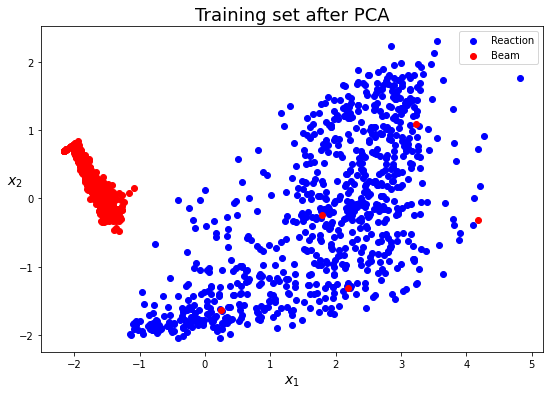

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_train_PCA = pca.fit_transform(X_train_stdsc)

# Latent Space Visualization
plot_latent_space(X_train_PCA, Labels_train, 'PCA')

One can see the separation between beam and reaction events is quite good. Only a few beam events are hidden 
between the reaction events.

## t-distributed Stochastic Neighbor Embedding (t-SNE)

[t-SNE](https://lvdmaaten.github.io/tsne/) is another method used for the visualization of high dimensional data.
One slight drawback for our purposes is that it does not give an explicit mapping. This means that new points cannot
be transformed and added after fitting the training set, altough one could just refit the entire dataset. 
t-SNE is also implemented in scikit-learn.

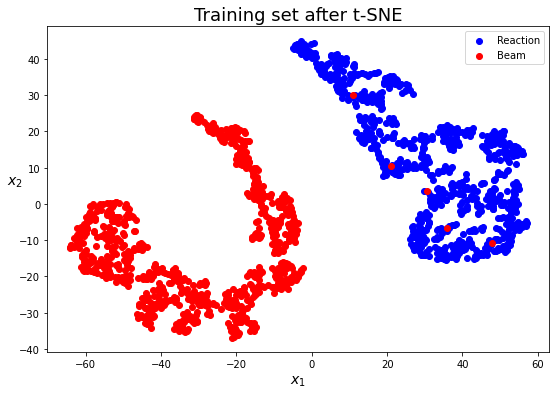

In [32]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_train_TSNE = tsne.fit_transform(X_train_stdsc)

# Latent Space Visualization
plot_latent_space(X_train_TSNE, Labels_train, 't-SNE')

Altough the shape differs from the one obtained with PCA, one again finds two well separated bodies 
and some beam events hiding among the 
reaction events. Remark that we use labels $x_1$ and $x_2$ for the two dimensions for both PCA and t-SNE, but that the coordinates are different for the the two methods.


#### Visualization of models using dimensionality reduction (PCA, t-SNE) 

The advantage of these two-dimensional feature sets is that visualization of the models becomes possible.
We restrict ourselves to showing the visualization results. The actual computations are stored inside the 
helper functions. The models used are the same ones as described before (logistic regression, random forest
and support vector machine), altough they are simplified versions (for example no grid search was used).

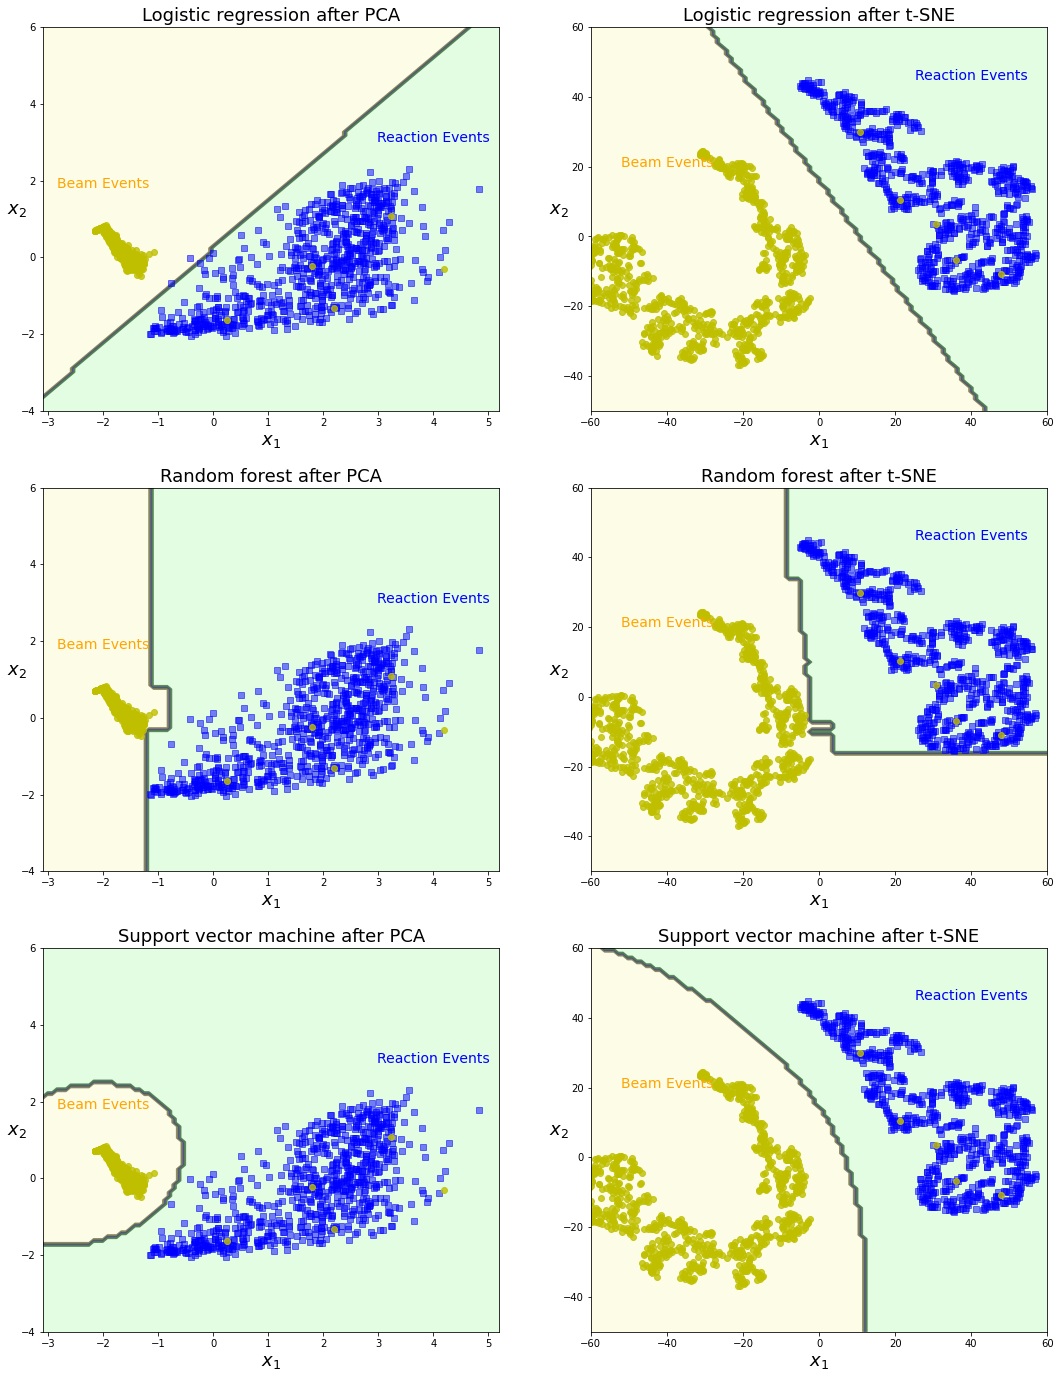

In [33]:
make_2d_vis(X_train_PCA,X_train_TSNE,Labels_train)

It is remarkable how the three models have predictions that agree well on the training set, even though all three use
a different decision boundary. One could again make predictions on the validation set using these models, however since
they use essentially the same information (albeit in a lower dimensionality) as the original models we choose not
to repeat this. In addition the same five misclassified points (in the training set) from earlier (see voting classifier confusion matrix) correspond to the beam events hidden here among the reaction events. Therefore we do expect similar results for the PCA and t-SNE reduced models.

##  AutoEncoder

An Autoencoder is a kind of neural networks which is trained to reproduce the input vector. We can picture this kind of networks as built of two main part:
1. Encoder, $h=f(x)$
2. Decoder, $r=g(h)$

If the dimensionality of the input vector $\vec{x}$ is higher than the hidden encoding layer $\vec{h}$ the autoencoder is called $\textbf{undercomplete}$.
We can use this type of network in order to learn a lower dimensionality representation of our data, in fact, while training the network in order to learn the mapping $g(f(x))=x$ the 
encoder network should learn a meaningful representation of our data which ensure the reconstruction through the decoder network.

<img src="img/autoencoder.svg" width=600;>

If our data shows clusters in Latent space we are confident that our network has learned a meaningfull lower dimensionality representation of our dataset.

First we normalize the data, for this example we normalize our dataset using the Min-Max Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler_mmsc = MinMaxScaler()
scaler_mmsc.fit(X)

X_train_mmsc = scaler_mmsc.transform(X_train)
X_val_mmsc = scaler_mmsc.transform(X_val)
X_test_mmsc = scaler_mmsc.transform(X_test)

In [35]:
# Building the autoencoder
autoencoder = tf.keras.Sequential()

# Input Layer
autoencoder.add(tf.keras.Input(shape=(5,)))

# Encoder Part
autoencoder.add(tf.keras.layers.Dense(4,activation='tanh', name='Encoder1'))
autoencoder.add(tf.keras.layers.Dense(2,activation='tanh', name='Encoder2'))

# Decoder Part
autoencoder.add(tf.keras.layers.Dense(4,activation='tanh', name='Decoder1'))
autoencoder.add(tf.keras.layers.Dense(5,activation='tanh', name='Decoder2'))

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder1 (Dense)             (None, 4)                 24        
_________________________________________________________________
Encoder2 (Dense)             (None, 2)                 10        
_________________________________________________________________
Decoder1 (Dense)             (None, 4)                 12        
_________________________________________________________________
Decoder2 (Dense)             (None, 5)                 25        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


Let's use as optimizer adam with the following parameters:
1. Learning rate: $10^{-3}$
2. $\beta_1 = 0.99$
3. $\beta_2 = 0.999$

As loss function we use the Mean Squared Error.

In [36]:
# Compiling Model

beta_1 = 0.99
beta_2 = 0.999

autoencoder.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=beta_1, beta_2=beta_2),
        loss      = tf.keras.losses.MeanSquaredError(),
        metrics   = ['mse']#[keras.metrics.MeanSquaredError()]
    )

In [37]:
# Training The Model
history = autoencoder.fit(
                            X_train_mmsc,
                            X_train_mmsc,
                            validation_data = (X_val_mmsc,X_val_mmsc),
                            batch_size=128,
                            epochs=250
                         )

Epoch 1/250
13/13 [==============================] - 0s 8ms/step - loss: 0.2663 - mse: 0.2663 - val_loss: 0.2482 - val_mse: 0.2482
Epoch 2/250
13/13 [==============================] - 0s 1ms/step - loss: 0.2312 - mse: 0.2312 - val_loss: 0.2164 - val_mse: 0.2164
Epoch 3/250
13/13 [==============================] - 0s 2ms/step - loss: 0.2026 - mse: 0.2026 - val_loss: 0.1905 - val_mse: 0.1905
Epoch 4/250
13/13 [==============================] - 0s 2ms/step - loss: 0.1789 - mse: 0.1789 - val_loss: 0.1687 - val_mse: 0.1687
Epoch 5/250
13/13 [==============================] - 0s 2ms/step - loss: 0.1585 - mse: 0.1585 - val_loss: 0.1499 - val_mse: 0.1499
Epoch 6/250
13/13 [==============================] - 0s 2ms/step - loss: 0.1406 - mse: 0.1406 - val_loss: 0.1334 - val_mse: 0.1334
Epoch 7/250
13/13 [==============================] - 0s 2ms/step - loss: 0.1246 - mse: 0.1246 - val_loss: 0.1188 - val_mse: 0.1188
Epoch 8/250
13/13 [==============================] - 0s 2ms/step - loss: 0.1109 - m

Now is possible to look at the lower dimensional space representation of our data by detaching the decoder part as follow:

In [38]:
# Defining Encoder
encoder       = autoencoder.get_layer("Encoder2").output
encoder_model = tf.keras.Model(inputs=autoencoder.input, outputs=encoder)

Let's project our input data on the latent space using the encoder, and use this for visualize it.

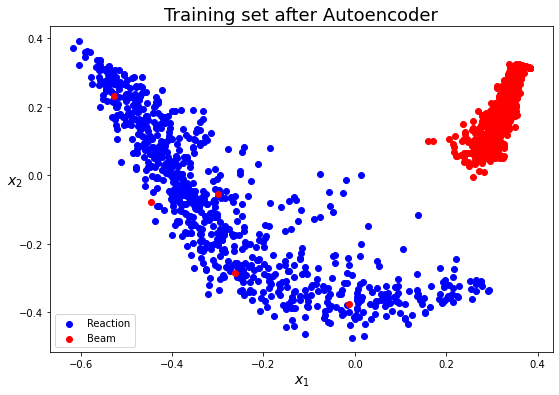

In [40]:
xtrain_latent = encoder_model.predict(X_train_mmsc)[:,0]
ytrain_latent = encoder_model.predict(X_train_mmsc)[:,1]
xtrain_encoder = np.array([np.array([a,b]) for a,b in zip(xtrain_latent, ytrain_latent)])

# Latent Space Visualization
plot_latent_space(xtrain_encoder, Labels_train, 'Autoencoder')

As we can see from the plot above the Encoder part of our networks seems to separate well our data since beam event are easily separable from the reactions ones. The only exceptions are represented by the same 5 events as we seen from the others algoritmhs.
Is possible to use this new representation as input for other classification algorithms.

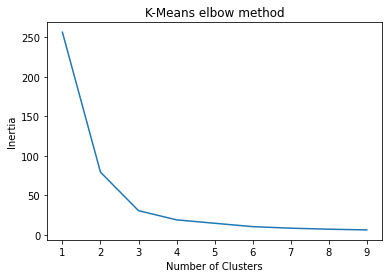

In [41]:
# Calculating Inertia for each K-Means with different number of clusters
encoder_pred_train = encoder_model.predict(X_train_mmsc)
encoder_pred_val = encoder_model.predict(X_val_mmsc)

from sklearn.cluster import KMeans
nr_clusters = range(1,10)
inertia = []

for k in nr_clusters:
    km = KMeans(n_clusters=k)
    km.fit(encoder_pred_train)
    inertia.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') #sum of squared error
plt.title('K-Means elbow method')
plt.plot(nr_clusters,inertia)

fig.tight_layout()
plt.show()

In [42]:
# Training Clustering k-Means

#Trying multiple Kmeans with different number of clusters
AE_clust2 = KMeans(n_clusters=2, random_state=1).fit(encoder_pred_train)
AE_clust3 = KMeans(n_clusters=3, random_state=1).fit(encoder_pred_train)
AE_clust4 = KMeans(n_clusters=4, random_state=1).fit(encoder_pred_train)
AE_clust5 = KMeans(n_clusters=5, random_state=1).fit(encoder_pred_train)

# Using function best_3cl_km in helper_function.py
AEKM2_pred_train, AEKM2_pred_val, AE_assoc2 = best_cl_km(2, AE_clust2, encoder_pred_train, encoder_pred_val, Labels_train)
AEKM3_pred_train, AEKM3_pred_val, AE_assoc3 = best_cl_km(3, AE_clust3, encoder_pred_train, encoder_pred_val, Labels_train)
AEKM4_pred_train, AEKM4_pred_val, AE_assoc4 = best_cl_km(4, AE_clust4, encoder_pred_train, encoder_pred_val, Labels_train)
AEKM5_pred_train, AEKM5_pred_val, AE_assoc5 = best_cl_km(5, AE_clust5, encoder_pred_train, encoder_pred_val, Labels_train)

KMeans with 2 clusters performance:
Max accuracy obtained is 0.9746  using the combination number : 1
Combination 1 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0)]
----------------------------------------------------------
KMeans with 3 clusters performance:
Max accuracy obtained is 0.9969  using the combination number : 5
Combination 5 has the "Cluster to Lables" association = [(0, 1.0), (1, 0.0), (2, 1.0)]
----------------------------------------------------------
KMeans with 4 clusters performance:
Max accuracy obtained is 0.9969  using the combination number : 7
Combination 7 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0), (2, 1.0), (3, 1.0)]
----------------------------------------------------------
KMeans with 5 clusters performance:
Max accuracy obtained is 0.9963  using the combination number : 14
Combination 14 has the "Cluster to Lables" association = [(0, 0.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 0.0)]
---------------------------------------------

The result with number of clusters equal to 3 seems to give better results, we will plot the performance of this KMeans model.

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 0.9969
MCC       : 0.9938


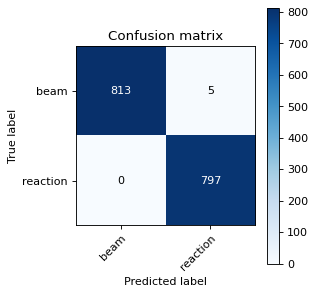


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 0.9946
MCC       : 0.9889


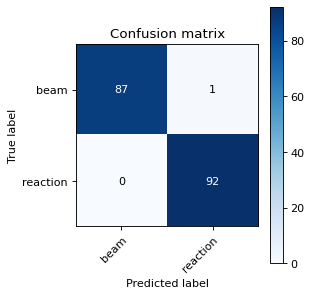

In [43]:
# Printing performances
print_model_performance(Labels_train,AEKM3_pred_train,"Training")
print_model_performance(Labels_val,AEKM3_pred_val,"Validation")

Let's visualize our train and validation set in Latent space: 

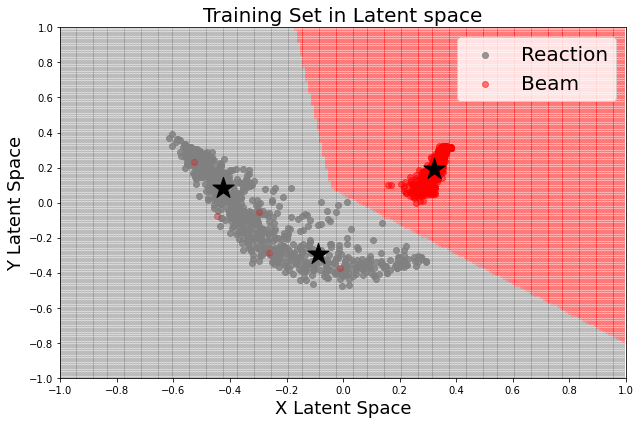

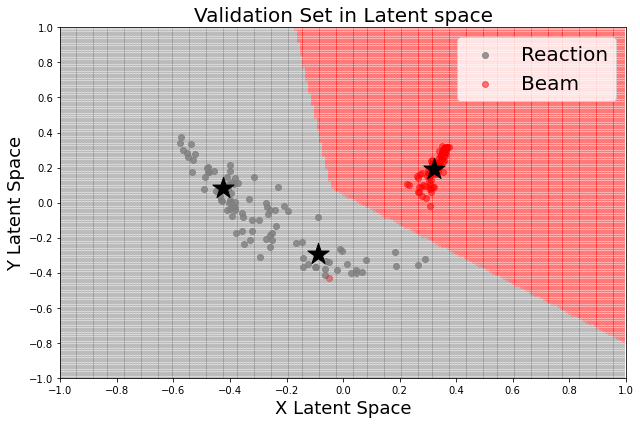

In [44]:
plot_kmeans_clustering(encoder_pred_train, Labels_train, AE_clust3, AE_assoc3, 'Training Set in Latent space')
plot_kmeans_clustering(encoder_pred_val, Labels_val, AE_clust3, AE_assoc3, 'Validation Set in Latent space')

#### Visualization of models using AutoEncoder
After the dimensionality reduction phase we can also use our labelled train set and classify it, in its new 2d representation, using other ML algorithms as seen above.

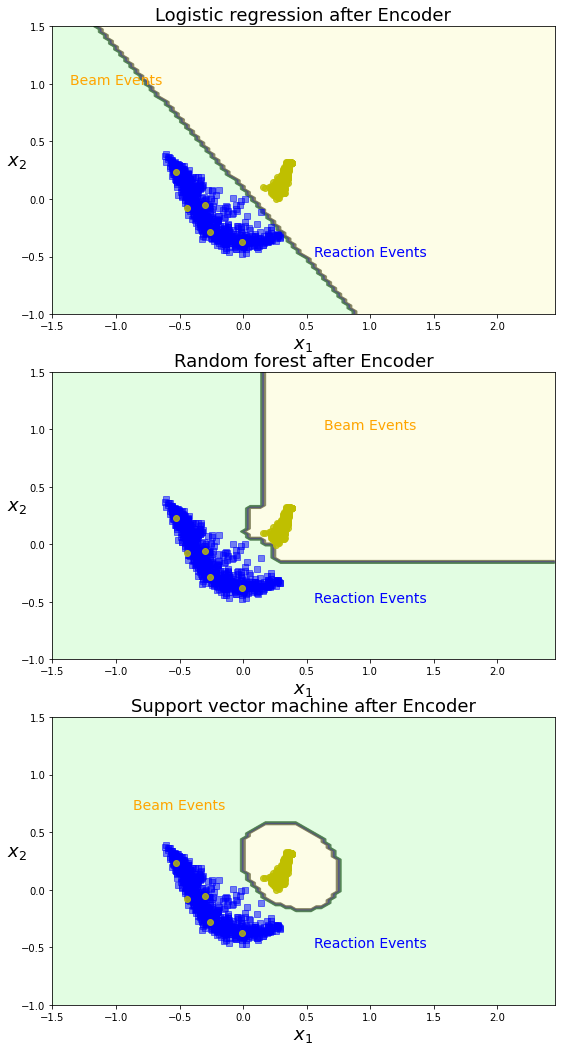

In [45]:
make_2d_vis_autoencoder(xtrain_latent, ytrain_latent, Labels_train)

#  <span style="color:darkred">Test Set Performances</span> 

After training and evaluation of the used ML methods, we now report the performance on the test set.
The first method used for this is the [voting classifier](#VotingClassifier) used above.

In [46]:

LR_pred_test = logreg2.predict(X_test_stdsc)
RFC_pred_test = RFC_best.predict(X_test_stdsc)
SVM_pred_test = SVM.predict(X_test_stdsc)

DNN_pred_test_pre = DNN_model.predict(X_test_stdsc)
DNN_pred_test = DNN_pred_test_pre > 0.5

not_used, KM3_pred_test, not_used2 = best_cl_km(3, KM_clust3, X_train_stdsc, X_test_stdsc, Labels_train)

# PCA-Based Classifiers
X_test_PCA  = pca.fit_transform(X_test_stdsc)

## PCA + Logistic Regression
PCA_LR_predictor = get_predictor('LR',X_train_PCA, Labels_train)
PCA_LR_pred_test = PCA_LR_predictor.predict(X_test_PCA)

## PCA + Random Forest
PCA_RF_predictor  = get_predictor('RF',X_train_PCA, Labels_train)
PCA_RF_pred_test  = PCA_RF_predictor.predict(X_test_PCA)

## PCA + SVM
PCA_SVM_predictor = get_predictor('SVM',X_train_PCA, Labels_train)
PCA_SVM_pred_test = PCA_SVM_predictor.predict(X_test_PCA)

# tSNE-Based Classifiers
X_test_tSNE  = tsne.fit_transform(X_test_stdsc)

## tSNE +  Logistic Regression
tSNE_LR_predictor = get_predictor('LR',X_test_tSNE, Labels_test)
tSNE_LR_pred_test = tSNE_LR_predictor.predict(X_test_tSNE)

## tSNE + Random Forest
tSNE_RF_predictor  = get_predictor('RF',X_test_tSNE, Labels_test)
tSNE_RF_pred_test  = tSNE_RF_predictor.predict(X_test_tSNE)

## tSNE + Support Vector Machine
tSNE_SVM_predictor = get_predictor('SVM',X_test_tSNE, Labels_test)
tSNE_SVM_pred_test  = tSNE_SVM_predictor.predict(X_test_tSNE)

# Autoencoder-based Classifiers
X_test_encoder = encoder_model.predict(X_test_mmsc)

## Encoder + Random Forest
Encoder_LR_predictor  = get_predictor('LR',encoder_pred_train, Labels_train)
Encoder_LR_pred_test  = Encoder_LR_predictor.predict(X_test_encoder)

## Encoder + Random Forest
Encoder_RF_predictor  = get_predictor('RF',encoder_pred_train, Labels_train)
Encoder_RF_pred_test  = Encoder_RF_predictor.predict(X_test_encoder)

## Encoder + Random Forest
Encoder_SVM_predictor  = get_predictor('SVM',encoder_pred_train, Labels_train)
Encoder_SVM_pred_test  = Encoder_SVM_predictor.predict(X_test_encoder)

# Calculate on CNN

CNN_pred_test_pre = my_model.predict(images_test)
CNN_pred_test = CNN_pred_test_pre > 0.5

# Voting
Vote_pred_test = np.zeros(len(DNN_pred_test))
total_vote_test = np.zeros(len(DNN_pred_test))

for i in range(len(DNN_pred_test)):

    TotalVotesTest = DNN_pred_test[i] + KM3_pred_test[i] + LR_pred_test[i]  + RFC_pred_test[i] + SVM_pred_test[i] + PCA_LR_pred_test[i] + PCA_RF_pred_test[i] + PCA_SVM_pred_test[i] + tSNE_LR_pred_test[i] + tSNE_RF_pred_test[i] + tSNE_SVM_pred_test[i] + Encoder_LR_pred_test[i] + Encoder_RF_pred_test[i] + Encoder_SVM_pred_test[i] + CNN_pred_test[i]
  
    if TotalVotesTest > 2:
        Vote_pred_test[i] = 1
    else:
        Vote_pred_test[i] = 0
        
print_model_performance(Labels_test,Vote_pred_test,"test")

KMeans with 3 clusters performance:
Max accuracy obtained is 0.9963  using the combination number : 6
Combination 6 has the "Cluster to Lables" association = [(0, 1.0), (1, 1.0), (2, 0.0)]
----------------------------------------------------------


NameError: name 'my_model' is not defined

The voting classifier performs well on the test set, with only 2 misclassified events. Similar to the training
and validation set performance, it misclassifies a few beam events as reaction events. 

#   <span style="color:darkred">Conclusions </span> 

We can conclude that basically all the models we tried permormed rather well on the training set (accuracy >98%, in some case >99%), as well as on the validation set, and test set. Starting form a simple approach, such as Logistic Regression, we reach already an extremely good result. We wanted to try all the possible models we knew to solve the problem, also most sofisticated ones, even though, for the simplicity of this task, this may have not been needed. 

#### Outliers:

There are 5 events that get consistently misclassified as to be reaction events, altought we know for sure they belong to beam class. We notice that from the 5 features we used to set our design matrix is not possible to assign to them a correct label. We do not expect any algorithm would be able to correctly classify them, based only on these features. One may want to extract other features in order to classify them correctly.
The only exception seems to be the Random Forest Classifier, which gives a perfect match on the training set, even though the accuracy is not as high on the validation set. RFC is known for slightly overfitting the data.
